In [1]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

## **archivos**

In [18]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

In [19]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        print(fname)
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)

file10_080124.mat
file11_080124.mat
file12_080124.mat


file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat


In [20]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    print(i)
    taus.append(aux.get_tau()[1])
    print(i)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14


## **psd defectos, sin interpolación**
Sin defectos, no hay trato de información perdida

In [21]:
signal_sin_defectos = []
hilbert_sin_defectos = []

for i, df in enumerate(defectos_frames):

    aux,aux_hilbert= df.get_no_defectos()
    signal_sin_defectos.append(aux)
    hilbert_sin_defectos.append(aux_hilbert)
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [22]:
signal_sin_defectos[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j
...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j
599996,0.177254,0.059242,0.000033,0.000033+0.000343j
599997,0.179227,0.061215,0.000050,0.000050+0.001284j
599998,0.179885,0.061872,0.000066,0.000066+0.001095j


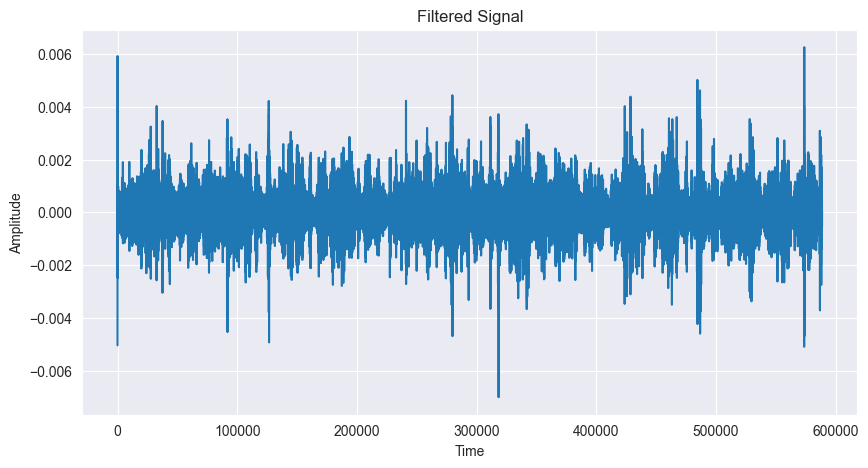

In [23]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and the sampling frequency
cutoff_freq = 200  # Specify the cutoff frequency in Hz
sampling_freq = 1000  # Specify the sampling frequency in Hz

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = cutoff_freq / (sampling_freq / 2)

# Design the filter coefficients using a Butterworth filter
order = 4  # Specify the filter order
b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

# Apply the filter to the signal
signal_filtered = []
for elem in signal_sin_defectos:
    elem = elem.dropna()
    aux = filtfilt(b, a, elem['Filtered Signal'])
    signal_filtered.append(aux)


# Plot the filtered signal
plt.figure(figsize=(10, 5))
plt.plot(signal_filtered[0], label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [24]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

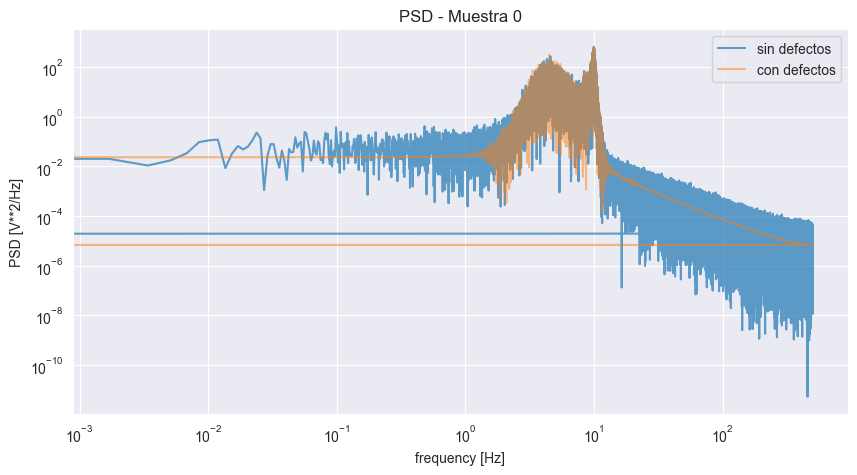

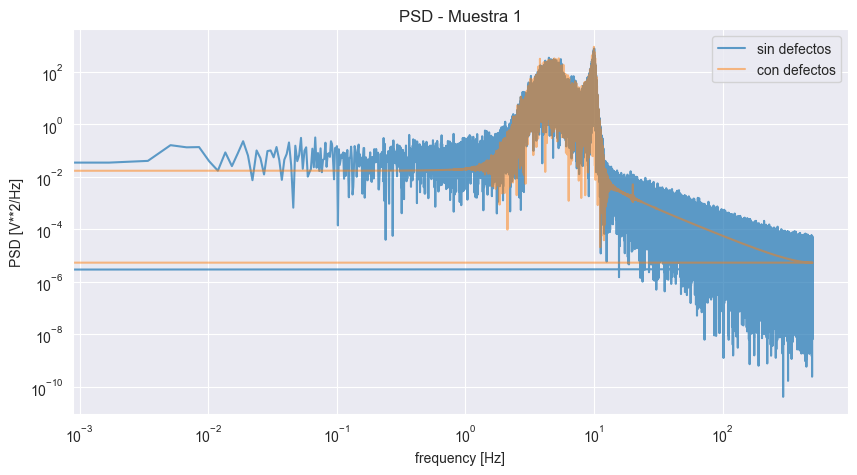

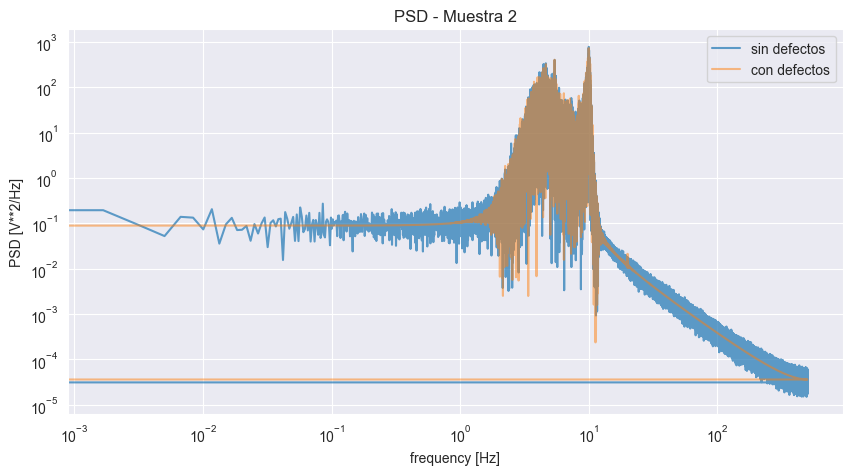

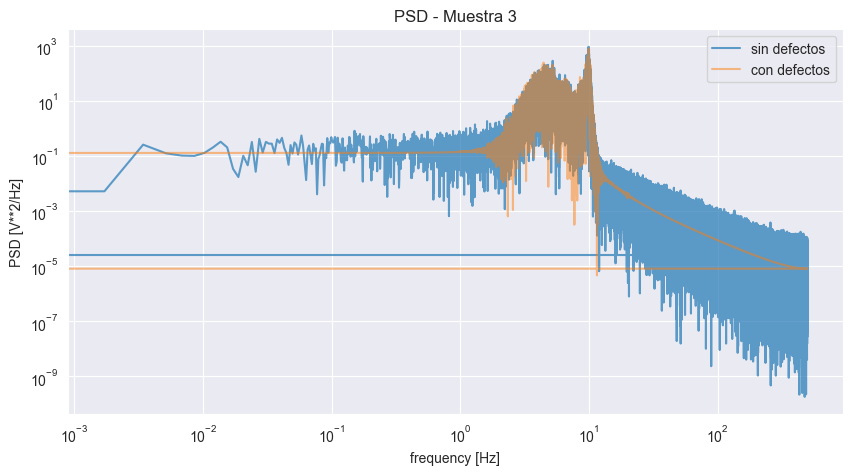

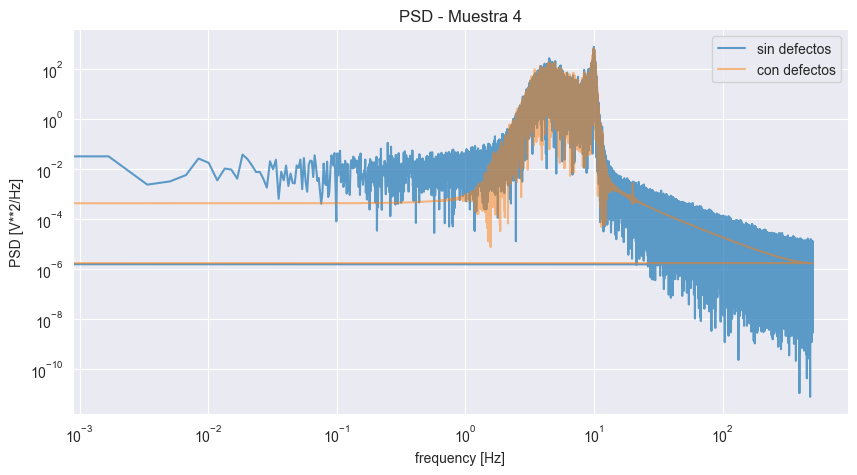

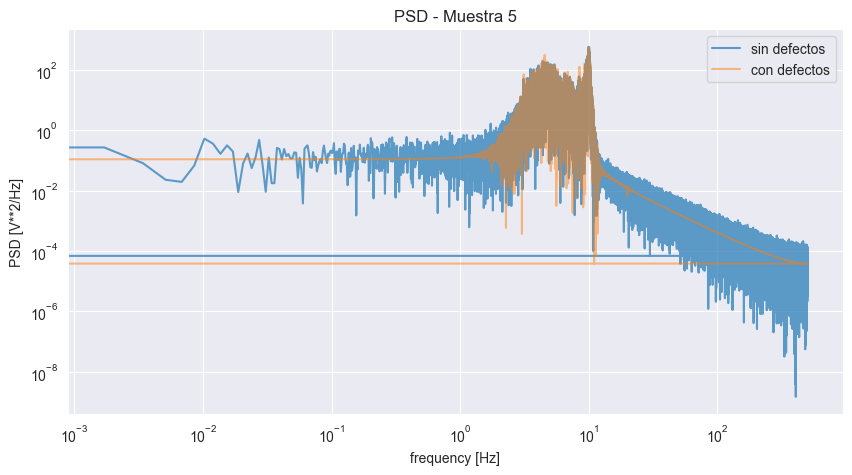

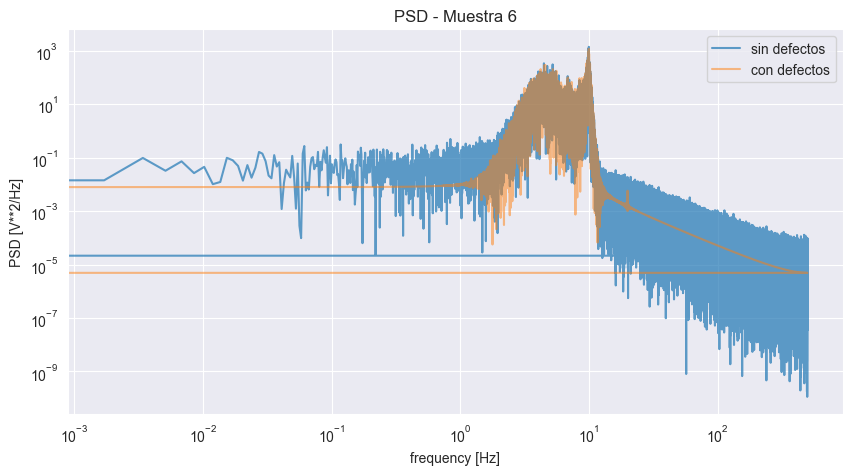

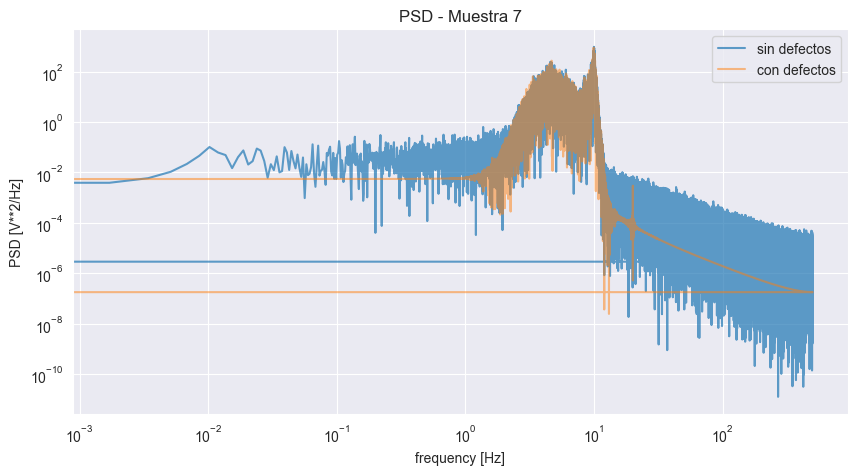

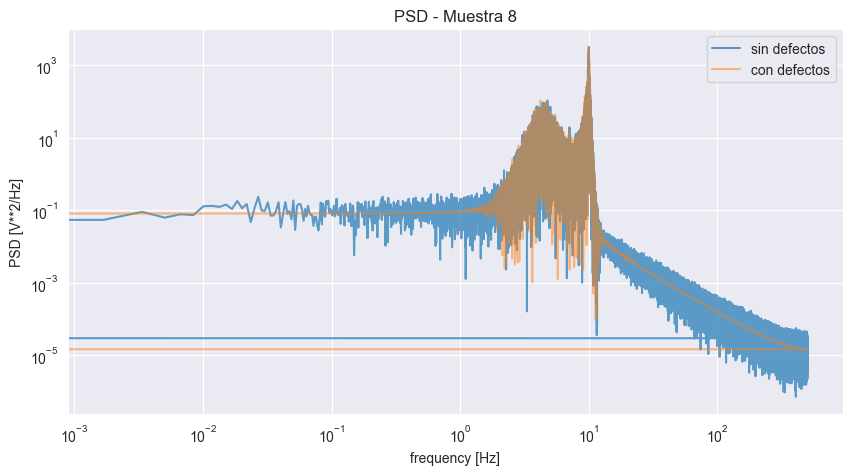

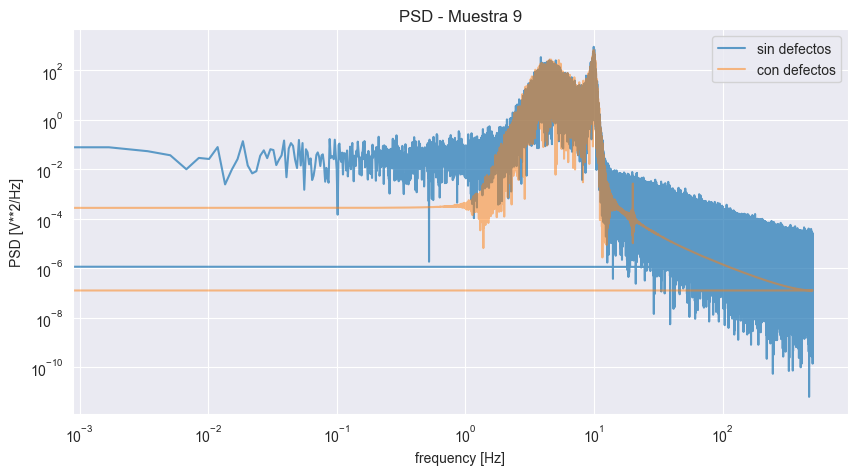

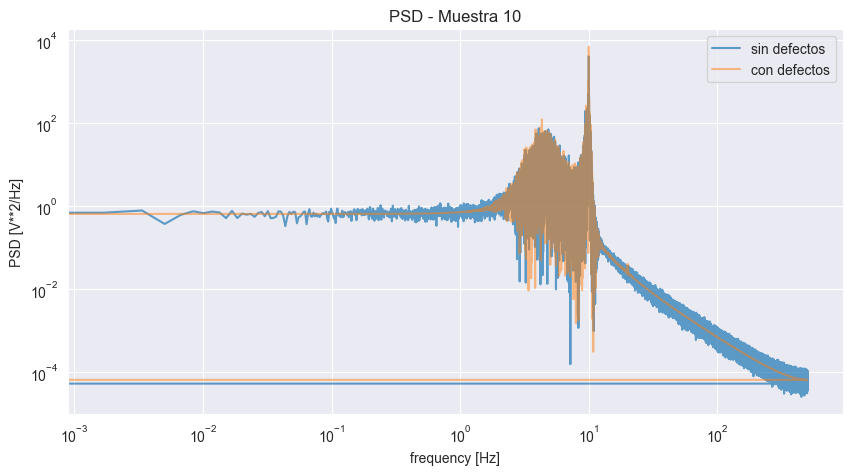

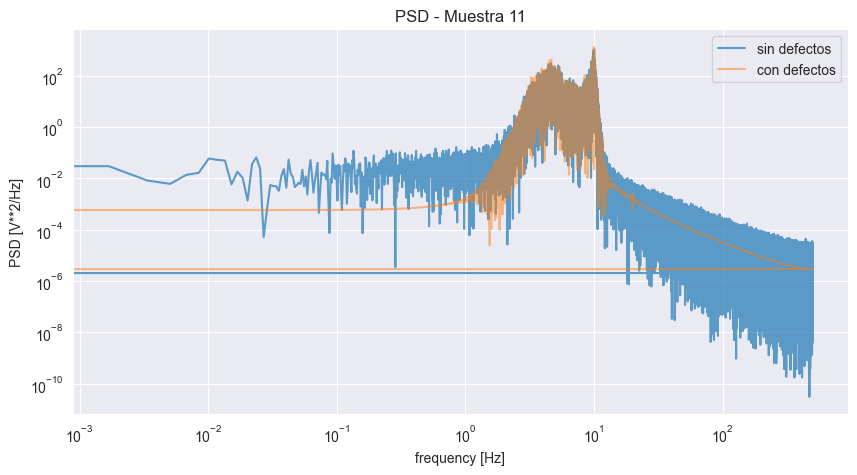

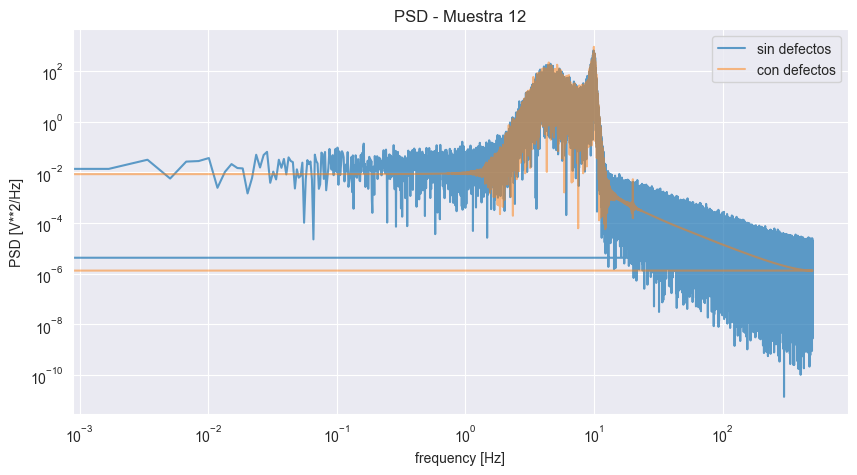

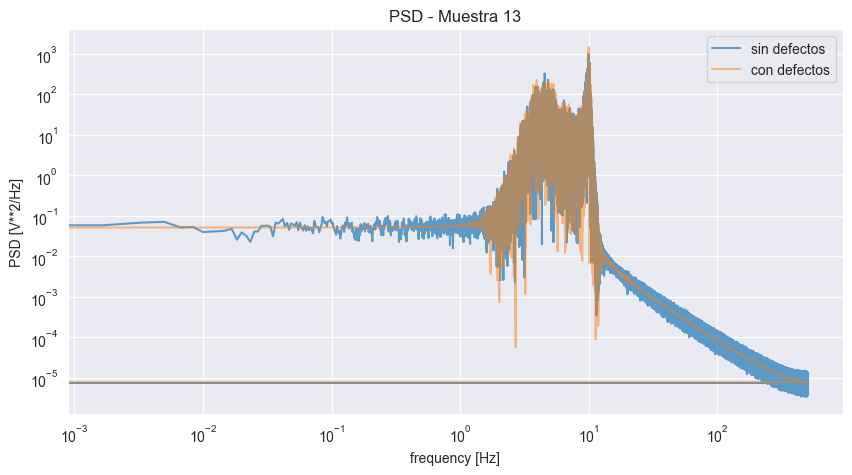

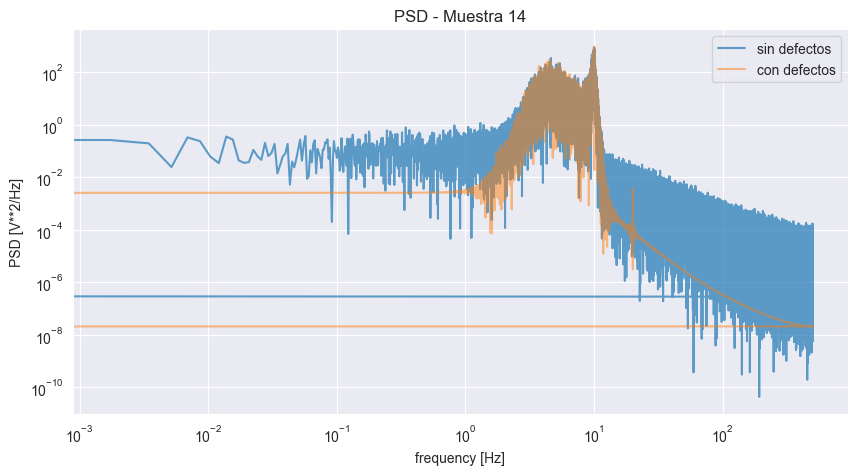

In [25]:
for i, elem in enumerate(signal_sin_defectos):
    figure = plt.figure(figsize=(10,5))
    elem = elem.dropna()
    freq1, psd1 = ffts(elem['Filtered Signal'], fs=1000)
    freq2, psd2 = ffts(frames[i]['Filtered Signal'])

    plt.loglog(freq1, psd1, label = 'sin defectos', alpha = 0.7)
    plt.loglog(freq2,psd2, label = 'con defectos', alpha = 0.5)

    plt.title(f"PSD - Muestra {i}")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

In [26]:
hilbert_sin_defectos[0].columns

Index(['Hilbert Transform', 'Amplitude', 'Instantaneous Phase',
       'Gradient Phase'],
      dtype='object')

### **welch**

In [27]:
x_sd = []
x_defectos = []

freqs_sd = []
freqs_defectos = []

x_amp =[]
freqs_amp = [] 

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    hilbert_sin_defectos[i] = hilbert_sin_defectos[i].dropna()
    f, pxx = signal.welch(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, pxx2 = signal.welch(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f3, pxx3 = signal.welch(hilbert_sin_defectos[i]['Amplitude'], 1000, nperseg= 1024, scaling='spectrum')
    x_sd.append(pxx)
    x_defectos.append(pxx2)
    x_amp.append(pxx3)

    freqs_sd.append(f)
    freqs_defectos.append(f2)
    freqs_amp.append(f3)

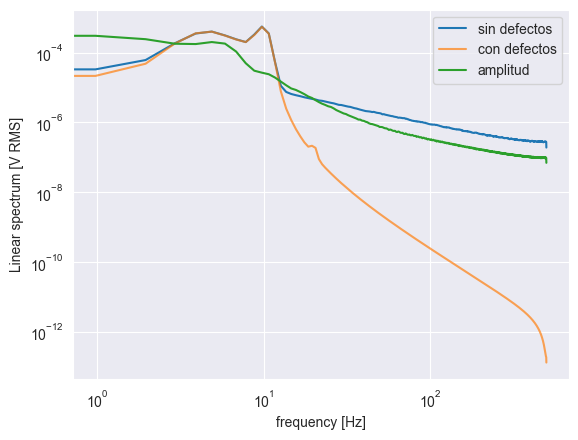

In [37]:
plt.figure()
plt.loglog(freqs_sd[14], np.sqrt(x_sd[14]), label = 'sin defectos')
plt.loglog(freqs_defectos[14], np.sqrt(x_defectos[14]), label = 'con defectos', alpha = 0.7)
plt.loglog(freqs_amp[14], np.sqrt(x_amp[14]), label = 'amplitud')
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.legend()
plt.show()

### **espectograma**

In [29]:
S_sd =[]
f_sd = []
t_sd = []

S_cd = []
f_cd = []
t_cd = []

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    f, t, Sxx = signal.spectrogram(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, t2, Sxx2 = signal.spectrogram(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    S_sd.append(Sxx)
    f_sd.append(f)
    t_sd.append(t)

    S_cd.append(Sxx2)
    f_cd.append(f2)
    t_cd.append(t2)


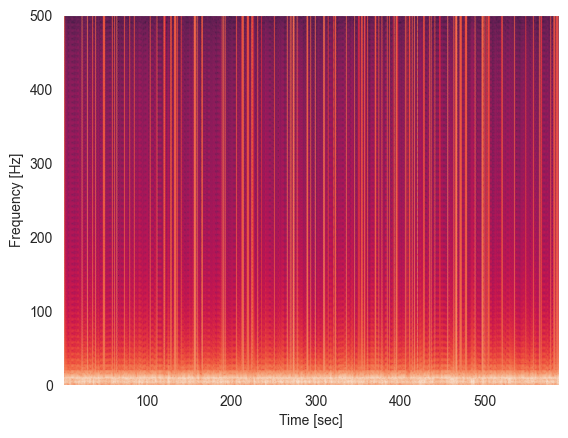

In [30]:
plt.pcolormesh(t_sd[0], f_sd[0], S_sd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

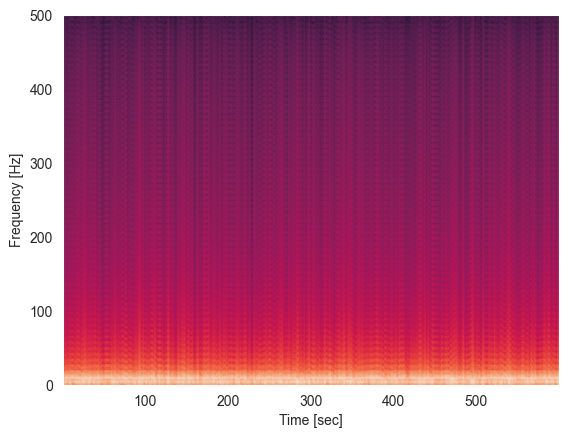

In [31]:
plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## **stats**

In [32]:
all_taus = pd.concat(taus).reset_index(drop=True)
all_taus.describe()

,duration,tau,app_time
count,1596.000000,1596.000000,1581.000000
mean,23.000627,12.551378,5530.811512
std,2.914347,1.700228,8626.902613
min,10.000000,10.000000,1.000000
25%,21.000000,12.000000,888.000000
50%,22.000000,12.000000,2799.000000
75%,24.000000,12.000000,6820.000000
max,29.000000,26.000000,138061.000000


**para espectro y pds**
* tomar ventanas de 2 segundos, 2k muestras y a eso sacar el espectro de potencia y el espectograma y promediarlos para ver su diferencia con el espectograma y el espectro de potencia de la señal completa.

**finalizar tesis**
* entrenar algoritmo de clasificación para encontrar los defectos en otros lados
* entrenar algoritmo de predicción

**otras cosas que usar**
* caracterizar la señal bruta y la señal sin defecto. Estudiar espectro, psd, etc.
* estudiar cosas que digo que son raras, los defectos tiempo vida medio, tiempo entre defecto, si se aumenta la amplitud de la señal, se aumenta la cantidad de defectos, etc.
* agregar un shaker para tener otra señal de referencia y ver si el modelo puede encontrar los defectos en esta nueva señal y si reconoce otras cosas.

In [33]:
fig = go.Figure(data=[go.Histogram(x=all_taus['app_time'])])
fig.update_layout(title='Histogram of Difference', xaxis_title='Difference', yaxis_title='Count')
fig.show()


#### **distribuciones**

In [34]:
appearance_time = all_taus['app_time'].values
appearance_time = (appearance_time[~np.isnan(appearance_time)])


2024-01-09 11:19:43.821 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


2024-01-09 11:19:44.959 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-09 11:19:44.997 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-09 11:19:45.098 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-09 11:19:45.379 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-09 11:19:45.793 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,6.866830e-10,2958.208851,2979.672102,inf,0.041597,8.171149e-03
lognorm,2.250487e-09,2944.924712,2961.022150,inf,0.047626,1.483541e-03
beta,2.546737e-09,3751.409631,3772.872882,inf,0.048459,1.150951e-03
chi2,2.804893e-09,3701.858307,3717.955745,inf,0.056018,9.401477e-05
norm,4.804826e-08,9557.081493,9567.813118,inf,0.260697,2.787733e-95


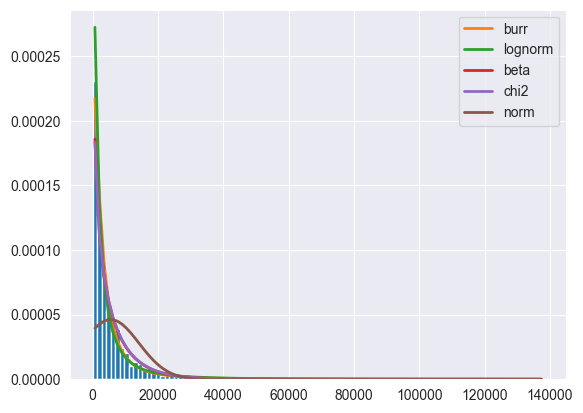

In [35]:
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()


2024-01-09 11:19:46.894 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


1570


2024-01-09 11:19:48.277 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-09 11:19:48.343 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-09 11:19:48.730 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-09 11:19:49.018 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-09 11:19:49.398 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,7.231980e-09,2546.920932,2562.997424,inf,0.041510,8.683434e-03
burr,1.206728e-08,2493.725307,2515.160631,inf,0.043536,5.046259e-03
beta,2.513609e-08,2972.027770,2993.463093,inf,0.087912,5.242708e-11
lognorm,1.136006e-07,2658.333220,2674.409712,inf,0.641979,0.000000e+00
norm,1.479105e-07,3203.509962,3214.227624,inf,0.216620,3.733967e-65


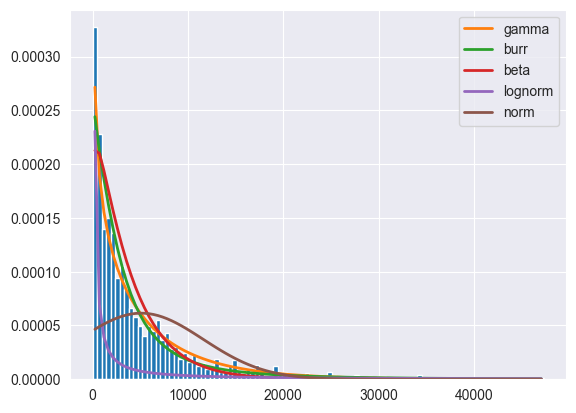

In [36]:
all_taus_2 = all_taus[all_taus['app_time'] <= 50000]
print(len(all_taus_2))

appearance_time = all_taus_2['app_time'].values
appearance_time = appearance_time[~np.isnan(appearance_time)]
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()